# cen2met - calculate summary metrics about centroid traces

We have centroids over time for both experimental (in `seg2cen`) and simulated (in `mod2cen`) traces. Now we want to find some summary metrics for them. Here we explore two possible metric options and then set about computing them.

In [1]:
import os
import copy
from pathlib import Path
import multiprocessing as mp

import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from workflow_colony_formation import utils

In [2]:
config = utils.load_step_config('cen2met', ['mod2cen', 'seg2cen', ])
    
# Find (and create if necessary) input and output dirs
root_dir = Path('../../..').resolve()
relative_local_staging = config.step_local_staging_dir
absolute_local_staging = root_dir / relative_local_staging
absolute_local_staging.mkdir(parents=True, exist_ok=True)

# Load the prior manifests for centroid logs
exp_manifest_fn = (absolute_local_staging / "../seg2cen/manifest.csv").resolve()
exp_manifest = pd.read_csv(exp_manifest_fn)

mod_manifest_fn = (absolute_local_staging / "../mod2cen/manifest.csv").resolve()
mod_manifest = pd.read_csv(mod_manifest_fn)
mod_manifest = mod_manifest[mod_manifest.type=='log']
mod_manifest.head(2)

,filepath,type,influence_decay,copy
200,runs/decay_0.043_copy_04.c6log,log,0.043,4
202,runs/decay_0.928_copy_08.c6log,log,0.928,8


First we'll load in a sample trace to work with

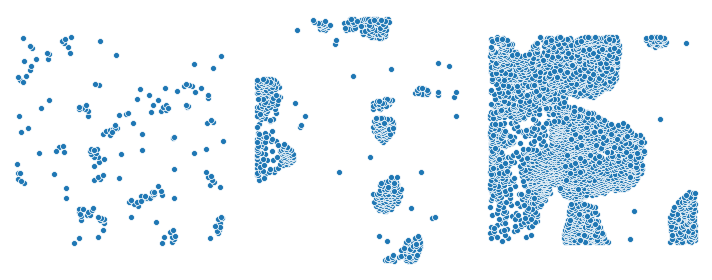

In [3]:
def load_trace(trace_fn):
    """Unify naming and pre-process experimental and c6 outputs"""
    trace = pd.read_csv(root_dir/trace_fn)
    trace.rename(columns=(dict(centroid_x='x', 
                               centroid_y='y', 
                               radius='r', 
                               time='t')), inplace=True)
    return trace
    

trial_trace = load_trace(exp_manifest.filepath[0])
trial_t = np.sort(trial_trace.t.unique())

fig, axs = plt.subplots(1, 3, figsize=(10,4))
for ax, t in zip(axs, [trial_t[i] for i in (0, len(trial_t)//2, -1)]):
    sns.scatterplot('x', 'y', sizes='r', data=trial_trace[trial_trace.t==t], ax=ax)
    ax.set(aspect=1)
    ax.axis('off')
plt.tight_layout()

This experimental trace is the trial one we'll show metrics for before working with any of the simulated traces. 

Now we need to build up our metrics:

In [4]:
def nearest_neighbor_distances(locs):
    """Find nearest neighbor distances for a series of locs"""
    dist_grid = scipy.spatial.distance.cdist(locs, locs)
    masked_grid = np.ma.array(dist_grid, mask=np.eye(len(locs)))
    return np.min(masked_grid, axis=1).data

def add_nearest_neighbor_column(trace):
    trace['nndist'] = np.nan
    times = np.sort(trace.t.unique())
    for t in times:
        inds = np.where(trace.t==t)[0]
        xy = trace.loc[inds].filter(('x','y')).values
        dists = nearest_neighbor_distances(xy)
        trace.loc[inds, 'nndist'] = dists
    return trace

We'll compute this for a sample trial

,area,x,y,cell_id,channel,original_czi,fluorophore,t,region,r,nndist
0,34.65,1024.97,1.68,1,0,20170711_I01_001.czi,EGFP,0,0,3.32,42.449518


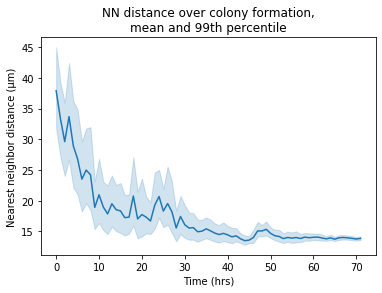

In [5]:
# Compute
trial_trace = add_nearest_neighbor_column(trial_trace)

# Plot
ax = sns.lineplot('t', 'nndist', data=trial_trace, ci=99)
ax.set(xlabel="Time (hrs)", 
       ylabel="Nearest neighbor distance (µm)",
       title="NN distance over colony formation,\nmean and 99th percentile")

# Show first row
trial_trace.head(1)

And then do so for the experimental and model traces, the number of which we'll let be determined by whether this is running interactively.

In [6]:
metrics_path = "met"
(absolute_local_staging/metrics_path).mkdir(parents=True, exist_ok=True)

def find_and_write_metrics(row, kind):
    row = copy.deepcopy(row)
    in_path = row.filepath if kind=="experiment" else 'local_staging/mod2cen/'+row.filepath
    trace = add_nearest_neighbor_column(load_trace(in_path))
    out_path = f"{metrics_path}/{kind}_{Path(in_path).stem}.csv"
    trace.to_csv(absolute_local_staging / out_path, float_format="%0.2f", index=False)
    row.filepath = str(relative_local_staging / out_path)
    row['type'] = kind
    return row
    

# Select which ones to run on
if config.interactive:
    exp = [(r,'experiment') for i, r in exp_manifest.iloc[:1].iterrows()]
    mod = [(r,'model') for i, r in mod_manifest.iloc[:1].iterrows()]
else:
    exp = [(r,'experiment') for i, r in exp_manifest.iterrows()]
    mod = [(r,'model') for i, r in mod_manifest.iterrows()]

Now process all of the trials, or just a smaller subset:

In [7]:
manifest = []
with mp.Pool(mp.cpu_count()) as pool:
    manifest += pool.starmap(find_and_write_metrics, exp)
    
with mp.Pool(mp.cpu_count()) as pool:
    manifest += pool.starmap(find_and_write_metrics, mod)

And write out the manifest boilerplate:

In [8]:
config.manifest = pd.DataFrame(manifest, index=range(len(manifest)))
config.metadata_columns = ['original_image_series', 'region', 'type', 'influence_decay', 'copy']
utils.dump_step_config(config)
config.manifest.head(2)

,filepath,original_image_series,region,type,influence_decay,copy
0,local_staging/cen2met/met/experiment_20170711_...,20170711_I01_0,0.0,experiment,NaN,NaN
1,local_staging/cen2met/met/model_decay_0.043_co...,NaN,NaN,model,0.043,4.0
